# Toeplitz and Circulant Matrix Eigenvalue Spectra

The Eigenvalues of Circulant and Toeplitz matrices are directly related to the Fourier transform. This notebook demonstrates this relation using some simple example covariance matrices.

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import jn

we first initialize two covariance matrices that are both based on a Bessel function as covariance function.

The first of these matrices is initialized by the Bessel function at the actual distance of point-point pairs on a 1d grid. Note that each grid point sees a different part of the Bessel function. The left-most point sees only the right part, the middle point a symmetric but smaller part around the origin and the right-most point the left part.

To construct a true circulant matrix, every point (every row) has to see the same extent of the covariance function. Effectively, this is only possible if the covariance function is periodic.

In the following cell, both types of covariance functions are computed, and then decomposed into their eigenvalue spectrum.

[(0, 11), (0, 11)]

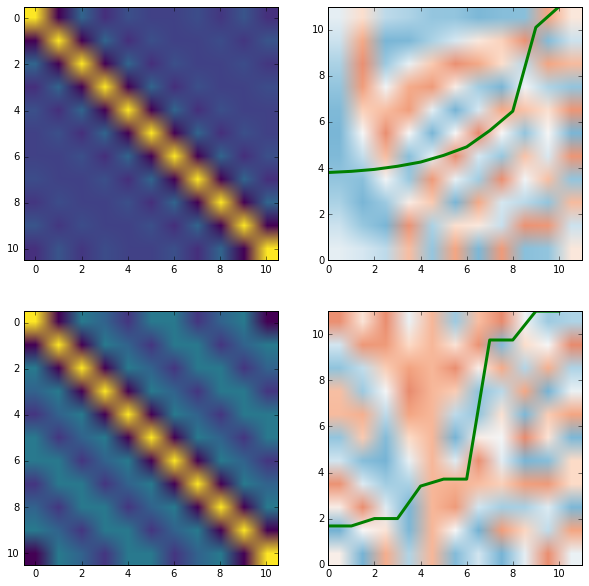

In [157]:
def get_1dcovariance_matrix(nx, scale):
    x = np.linspace(0., 1., nx)
    distances = x[:, None] - x[None, :]
    covariance = jn(0, scale * distances)
    return covariance

def get_1dcovariance_matrix_circulant(nx, scale):
    x = np.linspace(-0.5, 0.5, nx)
    covariance_middlerow = jn(0, scale * x)
    covariance = np.empty((nx, nx))
    for irow in range(nx):
        covariance[irow] = np.roll(covariance_middlerow, irow)
    covariance = np.roll(covariance, nx/2, axis=0)
    return covariance

nx = 11
covariance = get_1dcovariance_matrix(nx, 30)
evals, evecs = np.linalg.eigh(covariance)

covariance_circ = get_1dcovariance_matrix_circulant(nx, 40)
evals_circ, evecs_circ = np.linalg.eigh(covariance_circ)

norm_evecs = plt.Normalize(-3./np.sqrt(nx), 3./np.sqrt(nx))

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(covariance, cmap='viridis')
axes[0, 1].imshow(evecs, origin='lower', aspect='auto', extent=(0, nx, 0, nx),
                  cmap='RdBu', norm=norm_evecs)
axes[0, 1].plot(evals / evals.max() * nx, c='green', lw=3)
axes[0, 1].set(xlim=(0, nx), ylim=(0, nx))

axes[1, 0].imshow(covariance_circ, cmap='viridis')
axes[1, 1].imshow(evecs_circ, origin='lower', aspect='auto', extent=(0, nx, 0, nx),
                  cmap='RdBu', norm=norm_evecs)
axes[1, 1].plot(np.abs(evals_circ) / np.abs(evals_circ).max() * nx, c='green', lw=3)
axes[1, 1].set(xlim=(0, nx), ylim=(0, nx))

We now try to diagonalize this matrix using the Fourier basis. Note that this is NOT the exact Eigenbasis of the covariance matrix if it is not truly circulant.

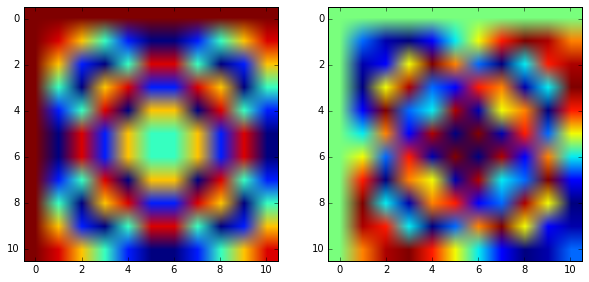

In [159]:
def get_1dfourier_basis(nx):
    ks = np.arange(nx)
    ns = np.arange(nx)
    basis = 1./np.sqrt(nx) * np.exp(-2j * np.pi * ks[None, :] * ns[:, None] / float(nx))
    return basis

fbasis = get_1dfourier_basis(nx)

fig, (col1, col2) = plt.subplots(1, 2, figsize=(10, 5))
col1.imshow(fbasis.real)
col2.imshow(fbasis.imag)

The diagonalized matrix looks like the following

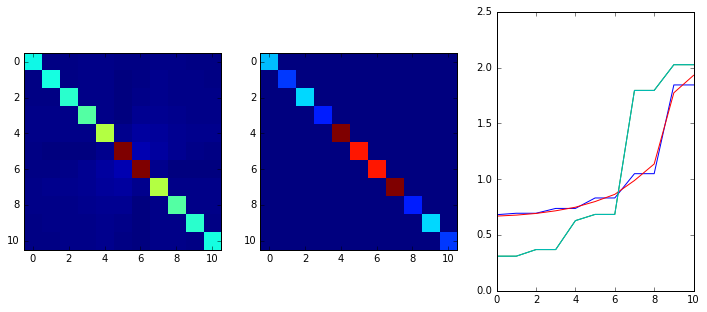

In [160]:
diagonalized = fbasis.dot(covariance).dot(fbasis.conjugate().T)
diagonalized_circ = fbasis.dot(covariance_circ).dot(fbasis.conjugate().T)

fig, (col1, col2, col3) = plt.subplots(1, 3, figsize=(12,5))
col1.imshow(np.abs(diagonalized), interpolation='nearest')
col2.imshow(np.abs(diagonalized_circ), interpolation='nearest')


evals_ana = np.abs(np.diag(diagonalized))
evals_ana_circ = np.abs(np.diag(diagonalized_circ))
evals_ana = np.sort(evals_ana)
evals_ana_circ = np.sort(evals_ana_circ)

col3.plot(evals_ana)
col3.plot(evals_ana_circ)
col3.plot(evals)
col3.plot(evals_circ)